In [1]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib.pyplot import colormaps as cmaps
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu as mwu

import src

FILE_IN = "data/final/snrna_variant_counts.tsv"
PNG="data/plots/snrna_variant_density.png"
SVG="data/plots/snrna_variant_density.svg"


In [2]:
df = (
    pd.read_csv(FILE_IN, sep="\t")
    .assign(
        allele_type=lambda x: pd.Categorical(
            x.allele_type, categories=["SNV", "Indel"], ordered=True
        ),
        gene_type=lambda x: pd.Categorical(
            x.gene_type, categories=["snRNA", "Pseudogene"], ordered=True
        ),
    )
    .sort_values(["allele_type", "gene_type", "variants_per_nt"])
    .check.head(5)
    .check.info()
)

<h5 style='text-align: left'><span style='color:None; background-color:None'>First 5 rows</span></h5>

,ensg,allele_type,symbol,gene_type,length,n_variants,variants_per_nt
3164,ENSG00000274452.1,SNV,U2,snRNA,191,1,0.005
3190,ENSG00000275616.1,SNV,U2,snRNA,191,9,0.047
3166,ENSG00000274585.2,SNV,RNU2-1,snRNA,188,9,0.048
3153,ENSG00000274062.1,SNV,U2,snRNA,191,10,0.052
3173,ENSG00000274862.1,SNV,U2,snRNA,191,10,0.052


<h5 style='text-align: left'><span style='color:None; background-color:None'>Info</span></h5>

<class 'pandas.core.frame.DataFrame'>
Index: 3292 entries, 3164 to 2529
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ensg             3292 non-null   object  
 1   allele_type      3292 non-null   category
 2   symbol           3292 non-null   object  
 3   gene_type        3292 non-null   category
 4   length           3292 non-null   int64   
 5   n_variants       3292 non-null   int64   
 6   variants_per_nt  3292 non-null   float64 
dtypes: category(2), float64(1), int64(2), object(2)
memory usage: 161.0+ KB



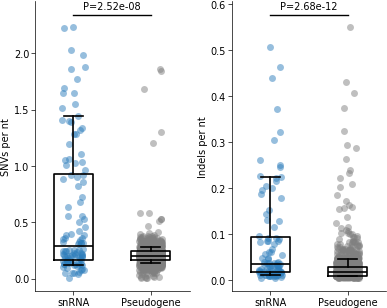

In [3]:
plt.style.use("src/default.mpltstyle")
lw = 1.2

fig, axs = plt.subplots(1, 2, figsize=(10 / 2.54, 8 / 2.54), constrained_layout=True)
color_snrna = cmaps["Blues"](0.7)
color_pseudo = "grey"
colors = [color_snrna, color_pseudo]
dfg_variant_type = df.groupby("allele_type", observed=True)
ax_labels = ["SNVs per nt", "Indels per nt"]

for ax, (variant_type, data), label in zip(axs, dfg_variant_type, ax_labels):
    dfg_gene_type = data.groupby("gene_type", observed=True)

    for (i, (gene_type, d)), c in zip(enumerate(dfg_gene_type), colors):
        d = d.copy()
        n = len(d)
        d["x"] = i + np.random.uniform(-0.15, 0.15, n)
        x = d["x"]
        y = d["variants_per_nt"]
        ax.boxplot(
            y,
            positions=[i],
            widths=[0.5],
            showfliers=False,
            boxprops=dict(color="black", lw=1.2),
            medianprops=dict(color="black", lw=1.2),
            whiskerprops=dict(color="black", lw=1.2),
            capprops=dict(color="black", lw=1.2),
            tick_labels=[gene_type],
            whis=[10, 90],
            zorder=10,
        )
        scatter = ax.scatter(x, y, alpha=0.5, lw=0, color=c, s=25)

        # # Annotate the three highest values in each group
        # d3 = d.nlargest(3, "variants_per_nt")
        # texts = []
        # for _, row in d3.iterrows():
        #     x = row["x"]
        #     y = row["variants_per_nt"]
        #     t = f'{row["symbol"]}'
        #     # text = ax.annotate(
        #     #     t,
        #     #     xy=(x, y),
        #     #     xytext=(1, 1),
        #     #     textcoords="offset points",
        #     #     # ha="left",
        #     #     # va="top",
        #     #     # ma="center",
        #     #     color=c,
        #     # )
        #     text = ax.text(x, y, t, color=c, ha="center", va="center")
        #     texts.append(text)

        # adjust_text(
        #     texts,
        #     ax=ax,
        #     objects=scatter,
        #     # only_move=dict(
        #         # text="x+y",
        #         # explode="x+",
        #     # ),
        #     # prevent_crossings=False,
        #     arrowprops=dict(arrowstyle="-", color=c, lw=0.5),
        #     # force_explode=(0.8, 0.8),
        #     # force_text=(0.5,0.5),
        #     # ensure_inside_axes=False,
        # )

    # Customize axes
    ax.set_ylabel(label)

    # Add significance labels
    _, y_max = ax.get_ylim()
    x0, x1 = 0, 1
    ax.plot([x0, x1], [y_max, y_max], color="black")

    snrna_density = data.loc[lambda x: x["gene_type"] == "snRNA", "variants_per_nt"]
    pseudo_density = data.loc[
        lambda x: x["gene_type"] == "Pseudogene", "variants_per_nt"
    ]

    p = mwu(snrna_density, pseudo_density, alternative="two-sided").pvalue
    p_label = f"P={p:.3n}"
    ax.annotate(
        p_label,
        xy=((x0 + x1) / 2, y_max),
        xytext=(0, 2),
        textcoords="offset points",
        ha="center",
        va="bottom",
    )

# Save figure
plt.savefig(PNG, dpi=600)
plt.savefig(SVG)


RNU6 / U6 genes - interpret with caution. Low complexity regions.
RNU2-2P no longer a pseudogene.